### Problem 1

#### Import Library

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

#### Load MNIST Data

In [2]:
def batch_maker(batch_size, img, label):
    img_len = len(img)
    random_idx = np.random.randint(img_len, size = batch_size)
    return img[random_idx], label[random_idx]

In [4]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [5]:
train_idx = ((np.argmax(mnist.train.labels, 1) == 1) | \
             (np.argmax(mnist.train.labels, 1) == 5) | \
             (np.argmax(mnist.train.labels, 1) == 6))
test_idx = ((np.argmax(mnist.test.labels, 1) == 1) | \
            (np.argmax(mnist.test.labels, 1) == 5) | \
            (np.argmax(mnist.test.labels, 1) == 6))

train_imgs   = mnist.train.images[train_idx]
train_labels = mnist.train.labels[train_idx]
test_imgs    = mnist.test.images[test_idx]
test_labels  = mnist.test.labels[test_idx]
n_train      = train_imgs.shape[0]
n_test       = test_imgs.shape[0]

print ("Packages loaded")
print ("The number of trainimgs : {}, shape : {}".format(n_train, train_imgs.shape))
print ("The number of testimgs : {}, shape : {}".format(n_test, test_imgs.shape))

Packages loaded
The number of trainimgs : 16583, shape : (16583, 784)
The number of testimgs : 2985, shape : (2985, 784)


#### Define an Autoencoder Shape

In [ ]:
# Shape of input and latent variable
def build_model(n_latent):
    n_input = 28*28

    # Encoder shape
    n_encoder1 = 500
    n_encoder2 = 300

    # Decoder shape
    n_decoder1 = 300
    n_decoder2 = 500

    weights = {
        'encoder1' : tf.Variable(tf.random_normal([n_input, n_encoder1], stddev=0.1)),
        'encoder2' : tf.Variable(tf.random_normal([n_encoder1, n_encoder2], stddev=0.1)),
        'latent' : tf.Variable(tf.random_normal([n_encoder2, n_latent], stddev=0.1)),
        'decoder1' : tf.Variable(tf.random_normal([n_latent, n_decoder1], stddev=0.1)),
        'decoder2' : tf.Variable(tf.random_normal([n_decoder1, n_decoder2], stddev=0.1)),
        'reconst' : tf.Variable(tf.random_normal([n_decoder2, n_input], stddev=0.1))
    }

    biases = {
        'encoder1' : tf.Variable(tf.random_normal([n_encoder1], stddev=0.1)),
        'encoder2' : tf.Variable(tf.random_normal([n_encoder2], stddev=0.1)),
        'latent' : tf.Variable(tf.random_normal([n_latent], stddev=0.1)),
        'decoder1' : tf.Variable(tf.random_normal([n_decoder1], stddev=0.1)),
        'decoder2' : tf.Variable(tf.random_normal([n_decoder2], stddev=0.1)),
        'reconst' : tf.Variable(tf.random_normal([n_input], stddev=0.1))
    }

    x = tf.placeholder(tf.float32, [None, n_input])

    def encoder(x, weights, biases):
        encoder1 = tf.add(tf.matmul(x, weights['encoder1']), biases['encoder1'])
        encoder1 = tf.nn.tanh(encoder1)

        encoder2 = tf.add(tf.matmul(encoder1, weights['encoder2']), biases['encoder2'])
        encoder2 = tf.nn.tanh(encoder2)

        latent = tf.add(tf.matmul(encoder2, weights['latent']), biases['latent'])

        return latent

    def decoder(latent, weights, biases):
        decoder1 = tf.add(tf.matmul(latent, weights['decoder1']), biases['decoder1'])
        decoder1 = tf.nn.tanh(decoder1)

        decoder2 = tf.add(tf.matmul(decoder1, weights['decoder2']), biases['decoder2'])
        decoder2 = tf.nn.tanh(decoder2)

        reconst = tf.add(tf.matmul(decoder2, weights['reconst']), biases['reconst'])

        return reconst

    LR = 0.0001

    latent = encoder(x, weights, biases)
    reconst = decoder(latent, weights, biases)
    loss = tf.square(tf.subtract(x, reconst))
    loss = tf.reduce_mean(loss)

    optm = tf.train.AdamOptimizer(LR).minimize(loss)

    init = tf.global_variables_initializer()

    n_batch = 50
    n_iter = 2500
    n_prt = 250

    # Run initialize
    # config = tf.ConfigProto(allow_soft_placement=True)  # GPU Allocating policy
    # sess = tf.Session(config=config)
    sess = tf.Session()
    sess.run(init)

    # Training cycle
    for epoch in range(n_iter):
        train_x, train_y = batch_maker(n_batch, train_imgs, train_labels)
        print(len(train_x))
        sess.run(optm, feed_dict={x : train_x})  

        if epoch % n_prt == 0:
            c = sess.run(loss, feed_dict={x: train_x})
            print ("Iter : {}".format(epoch))
            print ("Cost : {}".format(c))
    return c

In [ ]:
losses = []
for i in range(20):
    c = build_model(i+1)
    print("# latent variables: {}; loss: {}".format(i+1, c))
    losses.append(c)

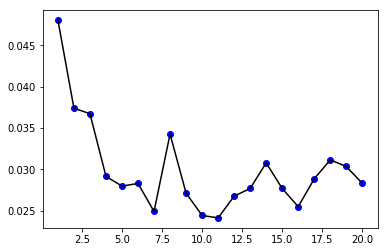

In [11]:
x = np.arange(1,21,1)
plt.plot(x, losses, 'bo', x, losses, 'k')
plt.show()

In [12]:
print(losses)

[0.048042677, 0.037394036, 0.036727294, 0.029137991, 0.027958129, 0.028283242, 0.024887042, 0.034260735, 0.027109116, 0.024407037, 0.024108918, 0.026740741, 0.027673936, 0.030771317, 0.027678179, 0.025466193, 0.028837796, 0.03113871, 0.030334326, 0.028298292]


It seems that 11 is the best candidate number of latent variables since it results in the lowest loss among others. As the number of latent variable increases, there seems to be a tendency to decrease the loss